# Bowel Sound Detection — YOHO-inspired approach

 **Project:** Bowel sound detection (classes: `b`, `mb`, `h`) with onset/offset regression inspired by the paper: *You Only Hear Once: A YOLO-like Algorithm for Audio
Segmentation and Sound Event Detection*.


paper's link: https://arxiv.org/abs/2109.00962
---
**Summary:**
- **Problem:** Detect bowel sound events in continuous audio and provide event type (`b`, `mb`, `h`) and precise start/end times.  
- **Why it matters:** Non-invasive monitoring of gut sounds can assist diagnosis and monitoring of gastrointestinal motility disorders; automated detection can scale screenings and enable remote patient monitoring.  
- **Approach:** We adapt the YOHO paradigm — transforming frame-based classification into a regression + classification network that predicts event presence and event boundaries directly. This yields faster inference and simpler post-processing.  
- **Results & impact:** (See K-Fold results below.) The model shows promising detection and temporal localization performance across folds; next steps include more data, refined augmentation, and clinical validation.
---

### Signal processing & feature extraction

**Bandpass filtering:** raw singals are preprocessed using a band-pass filter to remove low-frequency noise (`f_lowcut`= 100 Hz) and high-frequency noise (`f_highcut`= 2000 Hz). Filtering raw signals improves model robustness by discarding noise.

**Segmentation:** Audio is splited into fixed-length segments (in our algorithm we considered a 1 second).

**Feature extraction:** For each audio segment we compute the Mel-spectrogram (librosa). Mel features are effective at capturing time-frequency features.

### YOHO algorithm paper (Venkatesh et al., 2021)

Our algorithm is inspired by **"You Only Hear Once: A YOLO-like Algorithm for Audio Segmentation and Sound Event Detection"** (Venkatesh et al., 2021). Key ideas borrowed and adapted:

- **Grid-based temporal cells:** The algorithm splits each audio segment into frames (`n_frame`), and predict for each frame the presence of each class, the start and end time. the output label of the YOHO has the shape (n_segments, n_frames, 9), where 9 = n_classes*3. For each class we have 3 outputs: *presence*, *start offset*, *end offset*.
- **Transofrm the output into redable labels:** the output of the YOHO algorithm is later transformed into readable labels that respresents for each segment a list of events (start, end, event type).   

### Model architecture:

**Input:** Mel-spectrogram of a each segment (time × mel-bins).  
**Backbone:** The features extraction is done using Convolutional layers (optionally with pooling / batch-norm / dropout), designed to learn time-frequency features. (MobileNet architecture)  
**Temporal grid / heads:** The final layers map features to an output tensor of shape `(n_frames, 3 * n_classes)` where `n_classes=3` (`b`, `mb`, `h`). For each class per frame we predict:
- `p` — probability that the class is present in the frame (classification head)
- `t_start` — predicted start offset (regression) when present
- `t_end` — predicted end offset (regression) when present.

The activation function of the outpout layer is sigmoid.

**Loss:** The loss combines a classification loss (binary cross-entropy for presence) and regression losses (mean squared error for start and end offsets).

**Decoding the output:** After inference, outputs are thresholded on presence probabilities. Predicted start/end offsets are mapped to absolute timestamps within the segment.

## Training strategy & K-Fold cross-validation

To estimate generalization and reduce overfitting on limited data, we use K-Fold cross-validation. For each fold:
1. Split segments into training and validation sets.
2. Apply data augmentation on the training set.
3. Train the model from scratch (fresh initialization) on the training folds.
3. Evaluate on the held-out test fold and store metrics (F1, classification accuracy, and regression accuracy).

After K folds, we calculated the average mean for each metric and loss and report them in the analysis section below.


In [1]:
# Loading python libraries
import numpy as np
import pandas as pd
import librosa
from scipy.signal import butter, filtfilt
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
import random
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_audio(data_dir, audio_file_name):
    """
    Loads an audio file using librosa and returns the audio signal and its sampling rate.

    Args:
        data_dir (str): Path to the directory containing the audio file.
        audio_file_name (str): Name of the audio file (including extension, e.g., .wav).

    Returns:
        tuple:
            - audio (np.ndarray): 1D array containing the audio signal.
            - sr (int): Sampling rate of the audio in Hz.

    Raises:
        SystemExit: Exits the program if the audio file cannot be loaded or an error occurs.
    """
    try :
        audio, sr = librosa.load(data_dir+audio_file_name)
        print('Audio loaded successfully. Sample rate:', sr)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        exit(0)
    return audio, sr

In [4]:
def load_annotations(data_dir, annotations_file_name):
    """
    Loads event annotations from a text file into a pandas DataFrame and preprocesses them.
    The file is expected to be tab-separated with no header, containing three columns:
    start time (s), end time (s), and event type. The function converts the event types to lowercase,
    strips whitespace, and filters out unwanted event types ('v' and 'n').

    Args:
        data_dir (str): Path to the directory containing the annotation file.
        annotations_file_name (str): Name of the annotation file (including extension).

    Returns:
        pd.DataFrame: DataFrame with columns ['start', 'end', 'type'] containing the processed annotations.

    Raises:
        SystemExit: Exits the program if the file cannot be loaded or an error occurs during reading.
    """
    try:
        annotations = pd.read_csv(data_dir+annotations_file_name, sep='\t', header=None, names=['start','end','type'])
        annotations['type'] = annotations['type'].str.strip().str.lower()
        annotations = annotations[~annotations['type'].isin(['v','n'])]
        print('Annotations loaded successfully.First few rows:',annotations[:10])
    except Exception as e:
        print(f"Error loading annotations file: {e}")
        exit(0)
    return annotations

In [5]:
def plot_audio(audio, sr, title='Audio waveform'):
    """
    Plots the waveform of an audio signal over time.

    Args:
        audio (np.ndarray): 1D array containing the audio signal.
        sr (int): Sampling rate of the audio (samples per second).
        title (str, optional): Title of the plot. Default is 'Audio waveform'.

    Returns:
        None: Displays a matplotlib figure showing the audio waveform with time on the x-axis
              and amplitude on the y-axis.
    """
    plt.figure(figsize=(12, 3))
    times = np.arange(len(audio)) / sr
    plt.plot(times, audio)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

In [6]:
def bandpass_filter(data, sr, lowcut=100, highcut=2000, order=4):
    """
    Applies a Butterworth bandpass filter of order 4 to an audio signal to remove frequencies outside the specified range, effectively denoising the signal.

    Args:
        data (np.ndarray): 1D array containing the audio signal to be filtered.
        sr (int): Sampling rate of the audio (samples per second).
        lowcut (float, optional): Lower cutoff frequency in Hz. Default is 100 Hz.
        highcut (float, optional): Upper cutoff frequency in Hz. Default is 2000 Hz.
        order (int, optional): Order of the Butterworth filter. Higher values result in a steeper frequency roll-off. Default is 4.

    Returns:
        np.ndarray: Filtered audio signal with the same shape as input `data`.
    """
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [7]:
def compute_mel(audio, sr, n_mels=64, n_fft=512, hop_length=128, fmin=100, fmax=2000, win_length = 512):
    """
    Computes the Mel spectrogram of an audio signal, normalized and converted to decibel scale.
    The parameters are tuned for bowel sound audio characteristics.

    Args:
        audio (np.ndarray): 1D array of the raw audio signal.
        sr (int): Sampling rate of the audio (samples per second).
        n_mels (int, optional): Number of Mel bands. Default is 64.
        n_fft (int, optional): FFT window size. Default is 512.
        hop_length (int, optional): Number of samples between successive frames. Default is 128.
        fmin (float, optional): Minimum frequency for Mel filter bank. Default is 100 Hz.
        fmax (float, optional): Maximum frequency for Mel filter bank. Default is 2000 Hz.
        win_length (int, optional): Window size for FFT. Default is 512.

    Returns:
        np.ndarray: Mel spectrogram (in decibels) with shape (n_frames, n_mels). Transposed for frame-major format.
    """
    norm_audio = librosa.util.normalize(audio)
    bands = librosa.feature.melspectrogram(y=norm_audio, sr=sr, hop_length=hop_length, win_length = win_length, n_fft=n_fft, n_mels=n_mels, fmin=fmin,fmax=fmax)
    mel = librosa.core.power_to_db(bands)
    return mel.T

def plot_mel_segment(segment, sr, hop_length=80, fmin=100, fmax=2000, title='Mel Spectrogram'):
    """
    Plots a Mel spectrogram of an audio segment.

    Args:
        segment (np.ndarray): 2D array representing the Mel spectrogram (typically output of compute_mel).
        sr (int): Sampling rate of the audio.
        hop_length (int, optional): Number of samples between successive frames. Default is 80.
        fmin (float, optional): Minimum frequency displayed on the Mel scale. Default is 100 Hz.
        fmax (float, optional): Maximum frequency displayed on the Mel scale. Default is 2000 Hz.
        title (str, optional): Title of the plot. Default is 'Mel Spectrogram'.

    Returns:
        None: Displays a matplotlib figure of the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(segment, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [10]:
def plot_segmentation_window(audio, annotations, sr, segment_length, overlap, window_start_time=0, window_end_time=1):
      """
    Plots a segment of audio along with its original annotations and the corresponding segmented windows.

    The first subplot shows the raw audio waveform with shaded regions for annotated events.
    The second subplot shows the same audio divided into segments, with vertical markers indicating
    segment boundaries and shaded regions representing the events within each segment.

    Args:
        audio (np.ndarray): 1D array of the audio signal.
        annotations (pd.DataFrame): DataFrame with columns ['start', 'end', 'type'] containing events.
        sr (int): Sampling rate of the audio (samples per second).
        segment_length (float): Length of each segment in seconds.
        overlap (float): Fractional overlap between consecutive segments (0.0–1.0).
        window_start_time (float, optional): Start time (in seconds) of the window to plot. Default is 0.
        window_end_time (float, optional): End time (in seconds) of the window to plot. Default is 1.

    Returns:
        None: Displays the plot with two subplots:
            - Original audio with annotations.
            - Segmented audio with frame-wise labels and segment boundaries.
      """
      class_colors = {
      'b': 'red',
      'mb': 'blue',
      'h': 'green',
      'None': 'gray'
      }
      start_sample = int(window_start_time * sr)
      end_sample = int(window_end_time * sr)
      audio_clip = audio[start_sample:end_sample]

      annotations_window = annotations[(annotations['end'] > window_start_time) & (annotations['start'] < window_end_time)].copy()
      plt.figure(figsize=(15, 6))
      times_clip = np.arange(len(audio_clip)) / sr + window_start_time
      plt.subplot(2, 1, 1)
      plt.plot(times_clip, audio_clip, color='gray')
      for _, row in annotations_window.iterrows():
          event_type = row['type'].lower()
          color = class_colors.get(event_type, 'black')
          plt.axvspan(max(row['start'], window_start_time), min(row['end'], window_end_time), color=color, alpha=0.3, label=event_type)
      plt.xlabel('Time (s)')
      plt.ylabel('Amplitude')
      plt.title(f'Original Audio with Annotations ({window_start_time}-{window_end_time} s)')
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys())
      plt.subplot(2, 1, 2)
      plt.plot(times_clip, audio_clip, color='gray')
      x, y, seg_data = audio_to_segments(audio_clip, annotations_window,sr,segment_length,overlap)
      for segment_audio, labels_seg, (seg_start, seg_end) in zip(x, y, seg_data):
          plt.text(window_start_time+seg_start, max(audio_clip)*0.8, f"{seg_start:.2f}s", rotation=90, verticalalignment='bottom', fontsize=8)
          plt.text(window_start_time+seg_end, max(audio_clip)*0.8, f"{seg_end:.2f}s", rotation=90, verticalalignment='bottom', fontsize=8)
          for (norm_start, norm_end, event_type) in labels_seg:
              color = class_colors.get(event_type, 'black')
              if event_type != 'None':
                  plt.axvspan(seg_start + norm_start*segment_length, seg_start + norm_end*segment_length, alpha=0.3, color=color, label=event_type)
          plt.xlabel('Time (s)')
          plt.ylabel('Amplitude')
          plt.title(f'Segmented Audio with Labels ({window_start_time}-{window_end_time} s)')
          # Remove duplicate labels
          handles, labels = plt.gca().get_legend_handles_labels()
          by_label = dict(zip(labels, handles))
          plt.legend(by_label.values(), by_label.keys())
      plt.show()

In [11]:
def label_encoder_for_each_frame(annotations, segments_data, segment_length, n_frames, classes = ['b','mb','h']):
  """
    Converts segment-level annotations into a frame-wise label matrix suitable for training the YOHO deep learning model.
    Each segment is divided into `n_frames`, and for each frame, each class has a vector of three values:
    [presence_flag, normalized_start_time, normalized_end_time] where start and end times are normalized to the frame length (0 to 1).

    Args:
        annotations (list of list of tuples): List of segment annotations. Each element corresponds to a segment
                                              and contains a list of events. Each event is a tuple
                                              (start_time, end_time, event_type).
        segments_data (list of tuples): List of (segment_start_time, segment_end_time) for each segment.
        segment_length (float): Duration of each segment in seconds.
        n_frames (int, optional): Number of frames to divide each segment into. Default is 25.
        classes (list of str, optional): List of class names. Default is ['b', 'mb', 'h'].

    Returns:
        np.ndarray: Label tensor `Y` of shape (n_segments, n_frames, n_classes * 3).
                    For each frame and class:
                        - Index 0: presence flag (1 if class present in frame, 0 otherwise)
                        - Index 1: normalized start time of the event within the frame (0–1)
                        - Index 2: normalized end time of the event within the frame (0–1)
                    If no event overlaps a frame for a class, the values remain [0,0,0].
  """
  class_map = {cls: i for i, cls in enumerate(classes)}
  #print(class_map)
  n_classes = len(classes)
  n_segments = len(annotations)
  frame_length = segment_length / n_frames
  n_neurones_per_class=3
  # Initialize Y with zeros (automatically gives [0,0,0] for missing classes)
  Y = np.zeros((n_segments, n_frames, n_classes*n_neurones_per_class), dtype=np.float32)
  for seg_idx, segment_events in enumerate(annotations):
      # Loop over frames
      segment_start, segment_end = segments_data[seg_idx]
      for frame_idx in range(n_frames):
          frame_start = segment_start  + frame_idx * frame_length
          frame_end = segment_start + (frame_idx + 1) * frame_length
          # Check each event in this segment
          for start, end, cls in segment_events:
              if cls not in class_map:
                  continue
              cls_idx = class_map[cls]
              # Compute overlap of event with this frame
              overlap_start = max(start, frame_start)
              overlap_end = min(end, frame_end)
              if overlap_start < overlap_end:  # Event overlaps frame
                  norm_start = (overlap_start - frame_start) / frame_length
                  norm_end   = (overlap_end - frame_start) / frame_length
                  base_idx = cls_idx * 3
                  Y[seg_idx, frame_idx, base_idx + 1] = norm_start
                  Y[seg_idx, frame_idx, base_idx + 2] = norm_end
                  Y[seg_idx, frame_idx, base_idx] = 1.0  # presence flag
          # If no event of a class overlaps, Y remains [0,0,0] for that class (already initialized)
  return Y

In [12]:
def extract_segments_with_events(X, Y, SD):
  X_filtred, Y_filtred, SD_filtred= [], [], []
  for sgements, events, seg_data in zip(X,Y,SD):
    if len(events) == 1 and events[0] ==  (0.0,0.0,'None'):
      continue
    #print(sgements)
    X_filtred.append(sgements)
    Y_filtred.append(events)
    SD_filtred.append(seg_data)
  return np.array(X_filtred), Y_filtred, np.array(SD_filtred)

In [9]:
def audio_to_segments(audio, annotations, sr, segment_length=1, overlap=0.0, min_durations=None):
    """
    Splits a continuous audio signal into fixed-length segments and assigns events to each segment
    based on overlapping annotations. Optionally, segments can be augmented later (augmentation handled separately).

    Args:
        audio (np.ndarray): 1D array containing the raw audio signal.
        annotations (pd.DataFrame): DataFrame with columns ['start', 'end', 'type'] representing events in the audio.
        sr (int): Sampling rate of the audio (samples per second).
        segment_length (float, optional): Length of each segment in seconds. Default is 1 second.
        overlap (float, optional): Fractional overlap between consecutive segments (0.0–1.0). Default is 0.0.
        min_durations (dict, optional): Minimum duration (in seconds) required to keep an event per event type.
                                        Format: {'b': 0.1, 'mb': 0.2, 'h': 0.05}. Events shorter than this are ignored. Default is None.

    Returns:
        Three lists containing segment information:
            - X (list of np.ndarray): List of audio segments of length `segment_length`.
            - y (list of list of tuples): Corresponding events for each segment. Each event is a tuple
                                           (segment_start_time, segment_end_time, event_type). If no event, contains [(0.0, 0.0, 'None')].
            - seg_data (list of tuples): Start and end times (in seconds) of each segment, i.e., [(seg_start, seg_end), ...].
    """
    seg_samples = int(segment_length * sr)
    hop_samples = int(seg_samples * (1 - overlap))
    X = []
    y = []
    seg_data = []
    for start in range(0, len(audio) - seg_samples + 1, hop_samples):
        end = start + seg_samples
        seg_start_time = start / sr
        seg_end_time = end / sr
        segment_audio = audio[start:end]
        overlapping = annotations[(annotations['end'] > seg_start_time) & (annotations['start'] < seg_end_time)]
        events = []
        if not overlapping.empty:
            for _, row in overlapping.iterrows():
                event_start = max(row['start'], seg_start_time)
                event_end = min(row['end'], seg_end_time)
                duration = event_end - event_start
                # Keep only if duration >= min_duration for that type
                if min_durations is not None and row['type'] in min_durations:
                    if duration >= min_durations[row['type']]:
                        events.append((event_start, event_end, row['type']))
                else:
                    events.append((event_start, event_end, row['type']))
        # If no valid events, append 'None'
        if not events:
            events.append((0.0, 0.0, 'None'))
        X.append(segment_audio)
        y.append(events)
        seg_data.append((seg_start_time, seg_end_time))
    return X, y, seg_data

In [13]:
def augment_audio_segments_with_noise(audio_segments, labels, snr_range=(5, 20), seed=None):
    """
    Performs noise-based augmentation on audio segments, but only for segments containing real events.
    Segments labeled as (0.0, 0.0, 'None') are skipped. White noise is added to each segment to achieve
    a random signal-to-noise ratio (SNR) within the specified range.

    Args:
        audio_segments (list of np.ndarray): List of audio segments to augment. Each segment is a 1D array.
        labels (list of list of tuples): Corresponding labels for each segment. Each label is a list of events,
                                         where each event is a tuple (start_time, end_time, event_type).
        snr_range (tuple of float, optional): Range of SNRs in decibels for adding noise. Default is (5, 20).
        seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
         Two lists containing the augmented data:
            - augmented_segments (list of np.ndarray): Audio segments with added noise for real events.
            - augmented_labels (list of list of tuples): Corresponding labels (unchanged from input).
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    def add_noise_snr(y, snr_db):
        #Add white noise to reach the target SNR
        rms_signal = np.sqrt(np.mean(y**2))
        if rms_signal == 0:
            return y  # skip if silent
        rms_noise = rms_signal / (10**(snr_db / 20))
        noise = np.random.randn(len(y)) * rms_noise
        y_noisy = y + noise
        return y_noisy
    augmented_segments = []
    augmented_labels = []
    for seg, events in zip(audio_segments, labels):
        # Check if this segment contains real events
        if len(events) == 1 and events[0] == (0.0, 0.0, 'None'):
            continue  # skip dominant non-event segment
        # Random SNR for variability
        snr_db = random.uniform(*snr_range)
        # Add noise
        seg_noisy = add_noise_snr(seg, snr_db)
        # Append to outputs
        augmented_segments.append(seg_noisy)
        augmented_labels.append(events)  # same labels since noise doesn’t change events

    return augmented_segments, augmented_labels

In [14]:
def data_augmentation(X, Y, SD, n_augmentations=5, augmentation_prob=0.5):
    """
    Performs data augmentation on audio segments by applying noise-based transformations with a specified probability. Each segment can be augmented multiple times.

    Args:
        X (list or np.ndarray): List/array of audio segments (e.g., spectrograms or raw audio arrays).
        Y (list or np.ndarray): Corresponding labels/events for each audio segment.
        SD (list or np.ndarray): Start and end times (in seconds) of each segment, i.e., [(seg_start, seg_end), ...]
        n_augmentations (int, optional): Number of augmentation attempts per audio segment. Default is 5.
        augmentation_prob (float, optional): Probability of applying augmentation to each attempt. Default is 0.5.

    Returns:
         Three lists containing the augmented data:
            - X_aug_list: Augmented audio segments.
            - Y_aug_list: Corresponding augmented labels/events.
            - SD_aug_list: Original segment time repeated for augmented segments.
    """
    X_aug_list = []
    Y_aug_list = []
    SD_aug_list = []
    for audio_segment, events, seg_data in zip(X, Y, SD):
        for i in range(n_augmentations):
            if np.random.rand() < augmentation_prob:
                # Pass the single segment and its labels to the augmentation function
                X_aug_segment, events_aug_segment = augment_audio_segments_with_noise([audio_segment], [events])
                if X_aug_segment:
                    X_aug_list.append(X_aug_segment[0])
                    Y_aug_list.append(events_aug_segment[0])
                    SD_aug_list.append(seg_data)
    return X_aug_list, Y_aug_list, SD_aug_list


In [15]:
def compute_mean_std(X):
    """
    Computes the mean and standard deviation of a given array or dataset.

    Args:
        X (np.ndarray or list-like): Input data array for which to compute mean and standard deviation.

    Returns:
            mean (float): The arithmetic mean of all elements in X.
            std (float): The standard deviation of all elements in X.
    """
    mean = np.mean(X)
    std = np.std(X)
    return mean, std


In [ ]:
def hybrid_loss(y_true, y_pred, alpha=1.0, beta=1.0):
    """
    Computes a hybrid loss combining classification and regression components for multi-event detection (burst, multi-burst, harmonic burst).

    The classification part uses binary cross-entropy for event presence, and the regression part uses masked mean squared error for start/end times, only considering events that are present in the ground truth.

    Args:
        y_true (tf.Tensor): Ground truth tensor of shape (batch_size, n_features),
                            containing both event presence and start/end times.
                            Columns [0,3,6] -> presence for b, mb, h
                            Columns [1,2,4,5,7,8] -> start/end times for each event
        y_pred (tf.Tensor): Predicted tensor of the same shape as y_true,
                            containing predicted probabilities for event presence and start/end times.
        alpha (float, optional): Weight for the classification loss. Default is 1.0.
        beta (float, optional): Weight for the regression loss. Default is 1.0.

    Returns:
        tf.Tensor: A scalar tensor representing the combined hybrid loss.
    """
    # Classification loss
    cls_indices = tf.constant([0, 3, 6], dtype=tf.int32)
    cls_true = tf.gather(y_true, cls_indices, axis=-1)
    cls_pred = tf.gather(y_pred, cls_indices, axis=-1)
    cls_loss = tf.keras.losses.binary_crossentropy(cls_true, cls_pred)
    cls_loss = tf.reduce_mean(cls_loss)

    # Regression loss
    reg_indices = tf.constant([1, 2, 4, 5, 7, 8], dtype=tf.int32)
    reg_true = tf.gather(y_true, reg_indices, axis=-1)
    reg_pred = tf.gather(y_pred, reg_indices, axis=-1)

    # Mask: repeat presence 2x per event (for start, end)
    presence = cls_true  # shape (..., 3)
    mask = tf.repeat(presence, repeats=2, axis=-1)  # shape (..., 6)

    # Masked mean squared error
    squared_error = tf.square(reg_true - reg_pred)
    masked_error = squared_error * mask
    reg_loss = tf.reduce_sum(masked_error) / (tf.reduce_sum(mask) + 1e-8)

    # Combine classification & regression losses
    total_loss = alpha * cls_loss + beta * reg_loss
    return total_loss


In [ ]:
@tf.keras.utils.register_keras_serializable()
def classification_accuracy(y_true, y_pred, threshold=0.5):
    """
    Computes the classification accuracy for the three classes: burst (b), multi-burst (mb), and harmonic burst (h), based on the model predictions and ground truth labels.

    The function extracts the relevant class columns, binarizes the predictions using a threshold, and calculates the proportion of correct predictions across all classes and samples.

    Args:
        y_true (tf.Tensor): Ground truth tensor of shape (batch_size, n_features).
                            Expected to contain class probabilities or binary labels.
        y_pred (tf.Tensor): Predicted tensor of shape (batch_size, n_features).
                            Expected to contain predicted probabilities for each class.
        threshold (float, optional): Threshold to binarize predictions. Defaults to 0.5.

    Returns:
        tf.Tensor: A scalar tensor representing the classification accuracy.
                   If the computation results in NaN (e.g., empty input), returns 0.0.
    """
    cls_indices = tf.constant([0, 3, 6], dtype=tf.int32)
    cls_true = tf.gather(y_true, cls_indices, axis=-1)
    cls_pred = tf.gather(y_pred, cls_indices, axis=-1)

    binary_true = tf.cast(cls_true >= threshold, tf.float32)
    binary_pred = tf.cast(cls_pred >= threshold, tf.float32)

    correct = tf.cast(tf.equal(binary_true, binary_pred), tf.float32)
    acc = tf.reduce_mean(correct)
    return tf.where(tf.math.is_nan(acc), 0.0, acc)


In [ ]:
@tf.keras.utils.register_keras_serializable()
def masked_regression_accuracy(y_true, y_pred, tolerance=0.05):
    """
    Computes the masked regression accuracy for event start/end prediction of burst (b), multi-burst (mb), and harmonic burst (h) events.
    Only considers predictions for events that are present in the ground truth.
    The function compares predicted start/end times with the ground truth and counts a prediction as correct if it is within a specified tolerance.
    Accuracy is calculated only for the present events.

    Args:
        y_true (tf.Tensor): Ground truth tensor of shape (batch_size, n_features),
                            containing both event presence indicators and timing values.
                            Columns [0,3,6] are presence indicators for b, mb, h events.
                            Columns [1,2,4,5,7,8] are the corresponding start and end times.
        y_pred (tf.Tensor): Predicted tensor of the same shape as y_true,
                            containing predicted event presence and timing values.
        tolerance (float, optional): Maximum allowed deviation (in same units as timing)
                                     between predicted and true start/end times to count as correct. Default is 0.05.

    Returns:
        tf.Tensor: A scalar tensor representing the masked regression accuracy.
                   If no events are present or computation results in NaN, returns 0.0.
    """
    cls_indices = tf.constant([0, 3, 6], dtype=tf.int32)
    reg_indices = tf.constant([1, 2, 4, 5, 7, 8], dtype=tf.int32)

    presence = tf.gather(y_true, cls_indices, axis=-1)
    reg_true = tf.gather(y_true, reg_indices, axis=-1)
    reg_pred = tf.gather(y_pred, reg_indices, axis=-1)

    mask = tf.repeat(presence, repeats=2, axis=-1)
    correct = tf.cast(tf.abs(reg_true - reg_pred) <= tolerance, tf.float32)
    masked_correct = correct * mask

    acc = tf.math.divide_no_nan(tf.reduce_sum(masked_correct), tf.reduce_sum(mask))
    return tf.where(tf.math.is_nan(acc), 0.0, acc)


In [16]:
@tf.keras.utils.register_keras_serializable()
def classification_f1(y_true, y_pred, threshold=0.5):
    """
    Computes the macro F1 score for the three classes: burst (b), multi-burst (mb), and harmonic burst (h),based on the model predictions and ground truth labels.
    This function extracts the relevant columns for each class from the input tensors, applies a threshold to convert predictions to binary labels, and calculates the F1 score.

    Args:
        y_true (tf.Tensor): Ground truth tensor of shape (batch_size, n_features).
                            Expected to contain class probabilities or binary labels.
        y_pred (tf.Tensor): Predicted tensor of shape (batch_size, n_features).
                            Expected to contain predicted probabilities for each class.
        threshold (float, optional): Threshold to binarize predictions. Defaults to 0.5.

    Returns:
        tf.Tensor: A scalar tensor representing the F1 score. If the F1 score is NaN (e.g., when there are no positives), it returns 0.0.
    """
    cls_indices = tf.constant([0, 3, 6], dtype=tf.int32)
    cls_true = tf.gather(y_true, cls_indices, axis=-1)
    cls_pred = tf.gather(y_pred, cls_indices, axis=-1)

    binary_true = tf.cast(cls_true > threshold, tf.float32)
    binary_pred = tf.cast(cls_pred > threshold, tf.float32)

    tp = tf.reduce_sum(binary_true * binary_pred)
    fp = tf.reduce_sum((1 - binary_true) * binary_pred)
    fn = tf.reduce_sum(binary_true * (1 - binary_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return tf.where(tf.math.is_nan(f1), 0.0, f1)


In [17]:
layers_data = [
    # (layer_function, kernel, stride, num_filters)
    ([3, 3], 1,   64),
    ([3, 3], 2,  128),
    ([3, 3], 1,  128),
    ([3, 3], 2,  256),
    ([3, 3], 1,  256),
    ([3, 3], 2,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 2, 1024),
    ([3, 3], 1, 1024),
    ([3, 3], 1, 512),
    ([3, 3], 1, 256),
    ([3, 3], 1, 128)
]

def constrcut_model(layers_data, input_shape, dropout=0.2):
  """
    Constructs a deep convolutional neural network for frame-wise audio event detection
    using a combination of standard Conv2D and DepthwiseSeparableConv2D layers.

    Architecture:
        - Initial Conv2D layer followed by BatchNormalization, ReLU, and SpatialDropout2D.
        - Repeated blocks of DepthwiseConv2D -> BatchNorm -> ReLU -> Pointwise Conv2D -> BatchNorm -> ReLU -> SpatialDropout2D
          as specified in `layers_data`.
        - Reshaping 2D feature maps into sequences for frame-wise prediction.
        - Final Conv1D layer outputs per-frame predictions for multiple classes (presence, start, end).

    Args:
        layers_data (list of tuples): Each element defines a depthwise separable convolution block:
            ([kernel_height, kernel_width], stride, num_filters)
        input_shape (tuple): Shape of the input Mel spectrogram (height, width, channels).
        dropout (float, optional): Dropout rate for SpatialDropout2D layers. Default is 0.2.

    Returns:
        tf.keras.Model: A compiled Keras model that takes Mel spectrogram input and outputs
                        frame-wise predictions of shape (n_frames, n_classes*3).

    Example:
        model = constrcut_model(layers_data, input_shape=(64, 128, 1))
        model.summary()
    """
  mel_input = tf.keras.Input(shape=input_shape, name="mel_input")
  X = mel_input
  X = tf.keras.layers.Conv2D(filters = 32, kernel_size=[3, 3], strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-3), use_bias=False, activation=None, name = "layer1_conv")(X)
  X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer1_bn")(X)
  X = tf.keras.layers.ReLU(name="layer1_relu")(X)
  X = tf.keras.layers.SpatialDropout2D(dropout)(X)
  for i in range(len(layers_data)):
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=layers_data[i][0], strides = layers_data[i][1], depth_multiplier=1, padding='same', use_bias=False, activation=None, name="layer"+ str(i + 2)+"_depthwise_conv")(X)
    X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(i + 2)+"_depthwise_conv_bn")(X)
    X = tf.keras.layers.ReLU(name="layer"+ str(i + 2)+"_depthwise_conv_relu")(X)
    X = tf.keras.layers.Conv2D(filters = layers_data[i][2], kernel_size=[1, 1], strides=1, padding='same', kernel_regularizer=regularizers.l2(1e-3), use_bias=False, activation=None, name = "layer"+ str(i + 2)+"_pointwise_conv")(X)
    X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(i + 2)+"_pointwise_conv_bn")(X)
    X = tf.keras.layers.ReLU(name="layer"+ str(i + 2)+"_pointwise_conv_relu")(X)
    X = tf.keras.layers.SpatialDropout2D(dropout)(X)
  _, _, sx, sy = X.shape
  X = tf.keras.layers.Reshape((-1, int(sx * sy)))(X)
  n_classes = 3
  pred = tf.keras.layers.Conv1D(3*n_classes,kernel_size=1, activation="sigmoid")(X)
  model = tf.keras.Model(name='yoho_frames', inputs=mel_input, outputs=[pred])
  return model


In [18]:
def decode_model_output(model_output, segments_data, sr, n_frames, classes=['b', 'mb', 'h'], smooth_tol=1e-2):
    """
    Decode model output and combine overlapping/consecutive frames into single events per class,
    using the true segment start and end times.

    Args:
        model_output: np.array of shape (n_segments, n_frames, n_classes*3)
        segments_data: list of tuples [(segment_start_sec, segment_end_sec), ...]
            Real start/end of each segment in seconds.
        sr: sampling rate of audio
        n_frames: number of frames per segment
        classes: list of class names ['b','mb','h']
        smooth_tol: float — tolerance (in seconds) for merging adjacent same-class events

    Returns:
        decoded_annotations: list of list of events per segment
            [[(event_start_sec, event_end_sec, class), ...], ...]
    """
    n_segments = model_output.shape[0]
    n_classes = len(classes)
    frame_length_sec = (segments_data[0][1] - segments_data[0][0]) / n_frames
    decoded_annotations = []

    for seg_idx in range(n_segments):
        seg_start, seg_end = segments_data[seg_idx]
        frame_length_sec = (seg_end - seg_start) / n_frames
        segment_events = []

        for cls_idx, cls in enumerate(classes):
            current_event_start = None
            current_event_end = None

            for frame_idx in range(n_frames):
                frame_start_abs = seg_start + frame_idx * frame_length_sec
                base_idx = cls_idx * 3

                presence = model_output[seg_idx, frame_idx, base_idx]

                if presence > 0.5:
                    start = frame_start_abs + model_output[seg_idx, frame_idx, base_idx + 1] * frame_length_sec
                    end = frame_start_abs + model_output[seg_idx, frame_idx, base_idx + 2] * frame_length_sec

                    if current_event_start is None:
                        # Start new event
                        current_event_start = start
                        current_event_end = end
                    else:
                        # Merge overlapping or consecutive frames
                        if start <= current_event_end + 1e-6:
                            current_event_end = max(current_event_end, end)
                        else:
                            segment_events.append((current_event_start, current_event_end, cls))
                            current_event_start = start
                            current_event_end = end
                else:
                    # No presence: close current event if any
                    if current_event_start is not None:
                        segment_events.append((current_event_start, current_event_end, cls))
                        current_event_start = None
                        current_event_end = None

            # Close any ongoing event
            if current_event_start is not None:
                segment_events.append((current_event_start, current_event_end, cls))

        # Combine same-class events that are very close (≤ smooth_tol)
        if segment_events:
            merged_events = []
            segment_events.sort(key=lambda x: x[0])  # sort by start time

            prev_start, prev_end, prev_cls = segment_events[0]
            for start, end, cls in segment_events[1:]:
                if cls == prev_cls and start - prev_end <= smooth_tol:
                    prev_end = max(prev_end, end)
                else:
                    merged_events.append((prev_start, prev_end, prev_cls))
                    prev_start, prev_end, prev_cls = start, end, cls
            merged_events.append((prev_start, prev_end, prev_cls))
            segment_events = merged_events
        else:
            segment_events.append((0.0, 0.0, 'None'))

        decoded_annotations.append(segment_events)

    return decoded_annotations


In [19]:
data_dir = '/content/drive/MyDrive/Bowel sound detection project/data/'
audio_file_name_long = 'AS_1.wav'
annotations_file_name_long = 'AS_1.txt'
audio_file_name_short = '23M74M.wav'
annotations_files_name_short = '23M74M.txt'

In [20]:
# Loading the two singlas
audio_long, sr_long = load_audio(data_dir,audio_file_name_long)
audio_long = bandpass_filter(audio_long,sr_long)
audio_short, sr_short = load_audio(data_dir,audio_file_name_short)
audio_short = bandpass_filter(audio_short,sr_short)

Audio loaded successfully. Sample rate: 22050
Audio loaded successfully. Sample rate: 22050


In [21]:
# Loading the two annotations
annotations_long = load_annotations(data_dir,annotations_file_name_long)
annotations_short = load_annotations(data_dir,annotations_files_name_short)
annotations_short['type'] = annotations_short['type'].replace({'sb': 'b', 'sbs': 'b', 'mb': 'mb', 'h': 'h'})

Annotations loaded successfully.First few rows:        start       end type
1   0.988978  1.242612    h
2   1.278083  1.447401    b
3   1.496558  1.644029    b
4   1.731420  1.851581    b
5   4.189271  4.325818    b
6   5.106869  5.554744   mb
7   6.013543  6.122781    b
8   6.816441  6.931141    b
9   7.253392  7.799581   mb
10  7.848738  7.968900    b
Annotations loaded successfully.First few rows:       start       end type
0  1.124516  1.186244   sb
1  1.680065  1.733741   sb
2  1.918924  1.986019   sb
3  2.018225  2.267819   mb
4  2.565722  2.611347   sb
5  2.667707  3.352078   mb
6  3.480901  3.666084   mb
7  3.912994  4.082074   mb
8  4.269941  4.353139   sb
9  4.973099  5.230745   mb


In [22]:
annotations_combined = pd.concat([annotations_long, annotations_short], axis=0, ignore_index=True)
min_durations = annotations_combined.groupby('type').apply(lambda x: (x['end'] - x['start']).min()).reset_index(name='min_duration')
print(min_durations)

  type  min_duration
0    b      0.037573
1    h      0.086360
2   mb      0.080514


/tmp/ipython-input-1493284797.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_durations = annotations_combined.groupby('type').apply(lambda x: (x['end'] - x['start']).min()).reset_index(name='min_duration')


In [23]:
segment_length=1 # in seconds:
overlap = 0.5
n_frames_per_segment = 6
classes = ['b','mb','h']
min_durations = {'b': 0.037, 'h': 0.086, 'mb': 0.08}

In [24]:
X_long,Y_long,seg_data_long = audio_to_segments(audio=audio_long,annotations=annotations_long,sr=sr_long,segment_length=segment_length,overlap=overlap, min_durations=min_durations)
print(np.array(X_long).shape)
X_short,Y_short,seg_data_short = audio_to_segments(audio=audio_short,annotations=annotations_short,sr=sr_short,segment_length=segment_length,overlap=overlap, min_durations=min_durations)
print(np.array(X_short).shape)

(4423, 22050)
(600, 22050)


In [25]:
X = np.array(X_long + X_short)
print("Shape of the input combined signals = ", X.shape)
Y = Y_long + Y_short
seg_data = seg_data_long + seg_data_short

Shape of the input combined signals =  (5023, 22050)



--- Fold 1/5 ---
Epoch 1/500
371/371 ━━━━━━━━━━━━━━━━━━━━ 96s 167ms/step - classification_accuracy: 0.7573 - classification_f1: 0.1694 - loss: 6.1348 - masked_regression_accuracy: 0.2332 - val_classification_accuracy: 0.8748 - val_classification_f1: 0.0000e+00 - val_loss: 3.2296 - val_masked_regression_accuracy: 0.0390
Epoch 2/500
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7860 - classification_f1: 0.1080 - loss: 2.7354 - masked_regression_accuracy: 0.1193 - val_classification_accuracy: 0.8748 - val_classification_f1: 0.0000e+00 - val_loss: 1.6935 - val_masked_regression_accuracy: 0.0377
Epoch 3/500
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7947 - classification_f1: 0.2302 - loss: 1.5614 - masked_regression_accuracy: 0.1556 - val_classification_accuracy: 0.8567 - val_classification_f1: 0.0060 - val_loss: 1.1861 - val_masked_regression_accuracy: 0.0491
Epoch 4/500
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accurac

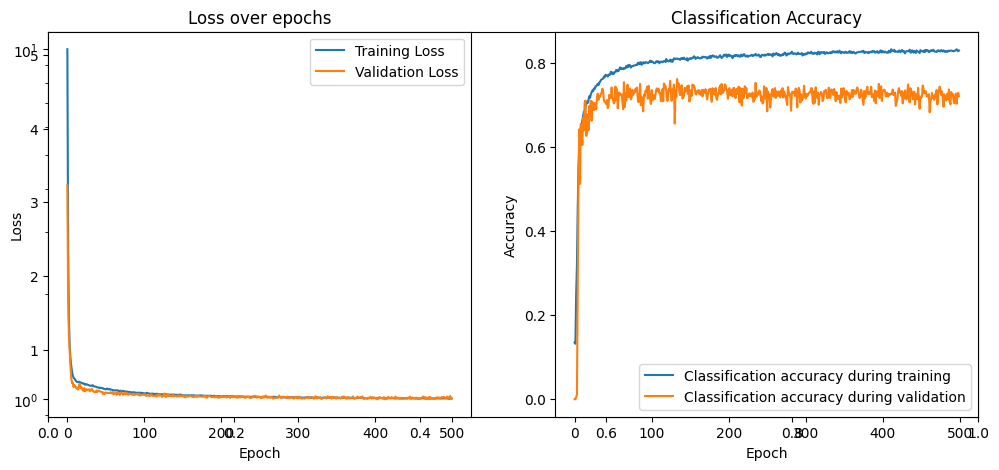


🔍 Testing the model for fold number (1)...

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - classification_accuracy: 0.9161 - classification_f1: 0.6746 - loss: 0.4104 - masked_regression_accuracy: 0.5511
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step
✅ Saved trained model for Fold 1 → /content/drive/MyDrive/Bowel sound detection project/models/final_trained_model_fold_1.keras

--- Fold 2/5 ---
Epoch 1/500
372/372 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - classification_accuracy: 0.7676 - classification_f1: 0.1672 - loss: 6.1572 - masked_regression_accuracy: 0.2248 - val_classification_accuracy: 0.8731 - val_classification_f1: 0.0000e+00 - val_loss: 3.2302 - val_masked_regression_accuracy: 0.0415
Epoch 2/500
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7909 - classification_f1: 0.0402 - loss: 2.7866 - masked_regression_accuracy: 0.1261 - val_classification_accuracy: 0.8731 - val_classification_f1: 0.0000e+00 - val_loss: 1.7088 - val_masked_regression_accuracy: 0.0369
Epoch 3

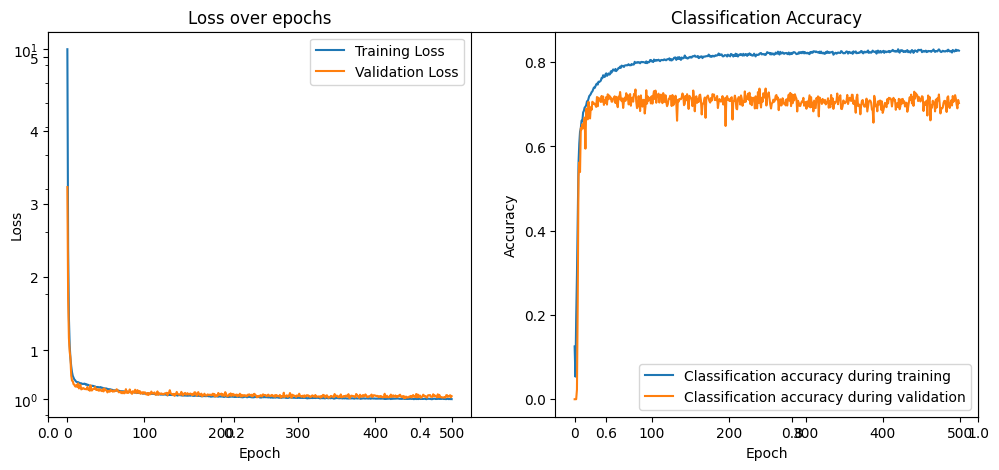


🔍 Testing the model for fold number (2)...

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - classification_accuracy: 0.9172 - classification_f1: 0.6251 - loss: 0.4079 - masked_regression_accuracy: 0.5203
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step
✅ Saved trained model for Fold 2 → /content/drive/MyDrive/Bowel sound detection project/models/final_trained_model_fold_2.keras

--- Fold 3/5 ---
Epoch 1/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - classification_accuracy: 0.7620 - classification_f1: 0.1824 - loss: 6.1840 - masked_regression_accuracy: 0.2210 - val_classification_accuracy: 0.8724 - val_classification_f1: 0.0000e+00 - val_loss: 3.3171 - val_masked_regression_accuracy: 0.0393
Epoch 2/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7867 - classification_f1: 0.1114 - loss: 2.8356 - masked_regression_accuracy: 0.1285 - val_classification_accuracy: 0.8724 - val_classification_f1: 0.0000e+00 - val_loss: 1.7610 - val_masked_regression_accuracy: 0.0381
Epoch 3/

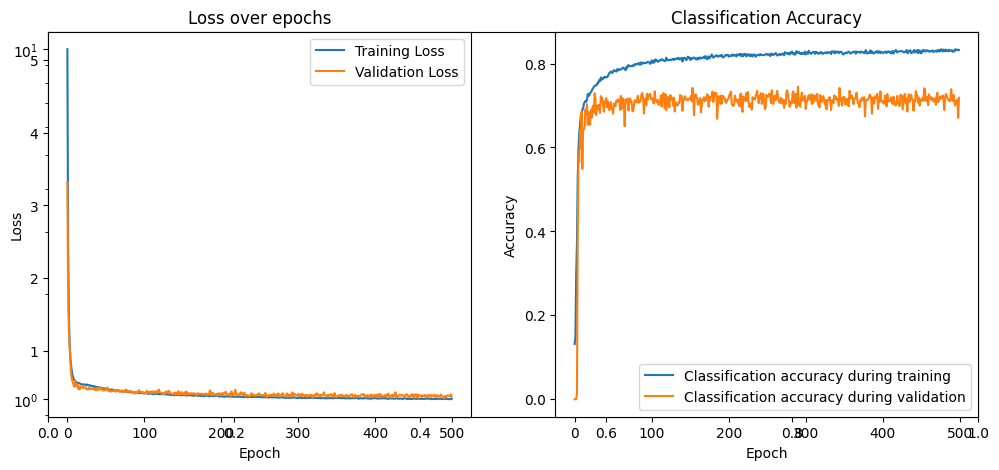


🔍 Testing the model for fold number (3)...

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - classification_accuracy: 0.9163 - classification_f1: 0.6650 - loss: 0.4161 - masked_regression_accuracy: 0.5390
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step
✅ Saved trained model for Fold 3 → /content/drive/MyDrive/Bowel sound detection project/models/final_trained_model_fold_3.keras

--- Fold 4/5 ---
Epoch 1/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step - classification_accuracy: 0.7621 - classification_f1: 0.1773 - loss: 6.1417 - masked_regression_accuracy: 0.2253 - val_classification_accuracy: 0.8715 - val_classification_f1: 0.0000e+00 - val_loss: 3.2754 - val_masked_regression_accuracy: 0.0363
Epoch 2/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7863 - classification_f1: 0.1355 - loss: 2.7956 - masked_regression_accuracy: 0.1226 - val_classification_accuracy: 0.8715 - val_classification_f1: 0.0000e+00 - val_loss: 1.7285 - val_masked_regression_accuracy: 0.0345
Epoch 3/5

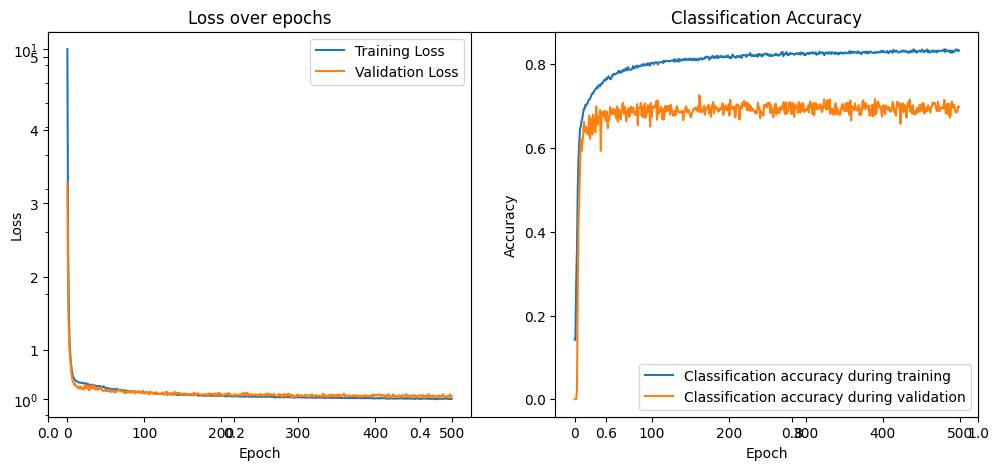


🔍 Testing the model for fold number (4)...

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - classification_accuracy: 0.9180 - classification_f1: 0.6752 - loss: 0.4158 - masked_regression_accuracy: 0.5673
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step
✅ Saved trained model for Fold 4 → /content/drive/MyDrive/Bowel sound detection project/models/final_trained_model_fold_4.keras

--- Fold 5/5 ---
Epoch 1/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - classification_accuracy: 0.7613 - classification_f1: 0.1753 - loss: 6.2214 - masked_regression_accuracy: 0.2352 - val_classification_accuracy: 0.8700 - val_classification_f1: 0.0000e+00 - val_loss: 3.4249 - val_masked_regression_accuracy: 0.0430
Epoch 2/500
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - classification_accuracy: 0.7909 - classification_f1: 0.0860 - loss: 2.9219 - masked_regression_accuracy: 0.1367 - val_classification_accuracy: 0.8700 - val_classification_f1: 0.0000e+00 - val_loss: 1.8168 - val_masked_regression_accuracy: 0.0386
Epoch 3

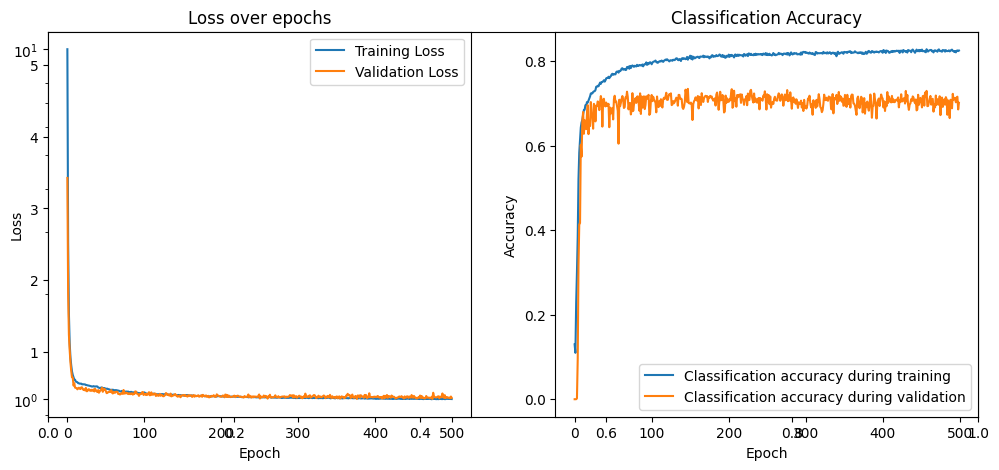


🔍 Testing the model for fold number (5)...

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - classification_accuracy: 0.9210 - classification_f1: 0.6616 - loss: 0.3936 - masked_regression_accuracy: 0.5058
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step
✅ Saved trained model for Fold 5 → /content/drive/MyDrive/Bowel sound detection project/models/final_trained_model_fold_5.keras

=== Cross-validation average results ===
Average Loss: 0.362827
Average classification_f1: 0.707872
Average classification_accuracy: 0.931482
Average masked_regression_accuracy: 0.561602


In [ ]:
# --- Load your data ---
X_all = X
Y_all = Y

if X_all is None or Y_all is None:
    raise RuntimeError("Could not find dataset variables. Make sure your features are in 'X' or 'X_train' and labels in 'Y' or 'Y_train'.")

X_all = np.asarray(X_all)
Y_all = np.asarray(Y_all, dtype=object)
seg_data = np.asarray(seg_data)

# K-Fold Cross-Validation
# Define the model saving directory
save_dir = "/content/drive/MyDrive/Bowel sound detection project/models/"
sr = sr_long
epochs = 500
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_losses = []
fold_f1 = []
fold_class_acc = []
fold_masked_acc = []
fold_metrics = []
fold_histories = []
fold = 0
for trainval_index, test_index in kf.split(X_all):
    fold += 1
    print(f"\n--- Fold {fold}/{n_splits} ---")

    # Split into fold-specific train+val and test
    X_trainval, X_test = X_all[trainval_index], X_all[test_index]
    Y_trainval, Y_test = Y_all[trainval_index], Y_all[test_index]
    Seg_trainval, Seg_test = seg_data[trainval_index], seg_data[test_index] # seg_data is now a numpy array

    # Further split train+val into train and val for this fold
    X_tr, X_val, Y_tr, Y_val, SD_tr, SD_val = train_test_split(
        X_trainval, Y_trainval, Seg_trainval, test_size=0.2, random_state=42, shuffle=True
    )
    # Data augmentation
    X_train_filtred, Y_train_filtred, SD_train_filtred = extract_segments_with_events(X_tr,Y_tr, SD_tr)
    X_aug,Y_aug,SD_aug = data_augmentation(X_train_filtred,Y_train_filtred,SD_train_filtred,n_augmentations=10,augmentation_prob=0.5)
    X_train_aug = np.concatenate([X_tr, X_aug],axis=0) # Corrected variable name from X_train to X_tr
    # Y_label_encoded
    Y_train_labled = label_encoder_for_each_frame(Y_tr,SD_tr,segment_length,n_frames_per_segment,classes=classes)
    Y_aug_labled = label_encoder_for_each_frame(Y_aug,SD_aug,segment_length,n_frames_per_segment,classes=classes)
    Y_train_aug_labled = np.concatenate([Y_train_labled, Y_aug_labled],axis=0)
    SD_train_aug = np.concatenate([SD_tr, SD_aug],axis=0)
    X_train_aug_shuff, out_train, out_sd_train = shuffle(X_train_aug, Y_train_aug_labled, SD_train_aug, random_state=42)
    in_train = np.array([compute_mel(x,sr) for x in X_train_aug_shuff])
    in_train = np.expand_dims(in_train,axis=-1)
    X_validation = np.array([compute_mel(x,sr) for x in X_val])
    in_validation = np.expand_dims(X_validation,axis=-1)
    # Normalization
    mean,std = compute_mean_std(in_train)
    in_train_norm = (in_train - mean) / (std + 1e-8)
    in_validation_norm = (in_validation - mean) / (std + 1e-8)
    out_validation = label_encoder_for_each_frame(Y_val,SD_val,segment_length,n_frames_per_segment,classes=classes)
    X_test = np.array([compute_mel(x,sr) for x in X_test])
    X_test = np.expand_dims(X_test,axis=-1)
    X_test = (X_test - mean) / (std + 1e-8)
    Y_test = label_encoder_for_each_frame(Y_test,Seg_test,segment_length,n_frames_per_segment,classes=classes)

    # Reinitialize model for each fold
    initial_learning_rate = 1e-3
    model= constrcut_model(layers_data,in_train_norm[0].shape, 0.3)
    best_model_path = os.path.join(save_dir, f"best_model_fold_{fold}.keras")
    final_model_path = os.path.join(save_dir, f"final_trained_model_fold_{fold}.keras")
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss = hybrid_loss, metrics = [classification_f1,classification_accuracy,masked_regression_accuracy])
    # Callbacks
    checkpoint_path = f'best_model_fold_{fold}.h5'
    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]
    # Train model
    history = model.fit(in_train_norm, out_train, validation_data=(in_validation_norm, out_validation), epochs=epochs, batch_size=32, verbose=1)
    fold_histories.append(history.history)

    # Plot metrics
    plt.figure(figsize=(12, 5))
    plt.yscale('log')
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model.history.history['loss'], label='Training Loss')
    plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plot classification accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model.history.history['classification_f1'], label='Classification accuracy during training')
    plt.plot(model.history.history['val_classification_f1'], label='Classification accuracy during validation')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate on this fold's test set

    print(f"\n Testing the model for fold number ({fold})...\n")

    scores = model.evaluate(X_test, Y_test, verbose=1)
    y_predict = model.predict(X_test)
    f1_score = classification_f1(Y_test,y_predict)
    fold_f1.append(f1_score)
    class_acc= classification_accuracy(Y_test,y_predict)
    fold_class_acc.append(class_acc)
    reg_acc = masked_regression_accuracy(Y_test,y_predict)
    fold_masked_acc.append(reg_acc)
    metric_names = model.metrics_names
    metrics_dict = dict(zip(metric_names, scores))
    fold_metrics.append(dict(zip(metric_names, scores)))

        # Store metrics individually if they exist
    fold_losses.append(metrics_dict.get('loss', np.nan))

    model.save(final_model_path)
    print(f" Saved trained model for Fold {fold} → {final_model_path}")
# Compute average test metrics across folds
avg_metrics = {}
for m in fold_metrics:
    for k, v in m.items():
        avg_metrics.setdefault(k, []).append(v)
avg_metrics = {k: float(np.mean(v)) for k, v in avg_metrics.items()}
print("\n=== Cross-validation average results ===")
print(f"Average Loss: {np.nanmean(fold_losses):.6f}")
print(f"Average classification_f1: {np.nanmean(fold_f1):.6f}")
print(f"Average classification_accuracy: {np.nanmean(fold_class_acc):.6f}")
print(f"Average masked_regression_accuracy: {np.nanmean(fold_masked_acc):.6f}")


In [ ]:
print("\n=== Cross-validation average results ===")

print(f"Average Loss: {np.nanmean(fold_losses):.6f}")
print(f"Average classification_f1: {np.nanmean(fold_f1):.6f}")
print(f"Average classification_accuracy: {np.nanmean(fold_class_acc):.6f}")
print(f"Average masked_regression_accuracy: {np.nanmean(fold_masked_acc):.6f}")



=== Cross-validation average results ===
Average Loss: 0.362827
Average classification_f1: 0.707872
Average classification_accuracy: 0.931482
Average masked_regression_accuracy: 0.561602


## — Analysis of Cross-Validation Results

After performing K-Fold cross-validation, we computed the mean performance across all folds to assess the model’s stability and generalization capacity.

| Metric                         | Average Value | Interpretation                                                                                                                                                                                                                          |
| :----------------------------- | :-----------: | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Loss**                       |     0.3628    | Indicates a good optimization balance between classification and regression tasks. Lower loss suggests convergence without overfitting.                                                                                                 |
| **Classification F1-score**    |   **0.7079**  | Reflects the model’s ability to correctly detect and classify bowel sound events (`b`, `mb`, `h`). A mean F1 around 0.71 is solid given the acoustic variability and class imbalance typical in biomedical audio.                       |
| **Classification Accuracy**    |   **0.9315**  | The model correctly identifies the presence or absence of bowel sounds in over 93% of frames, confirming strong discriminative performance.                                                                                             |
| **Regression Accuracy** |   **0.5616**  | Measures how well the model predicts start and end times when events are present. An accuracy around 56% suggests reasonable boundary localization. |

### Interpretation

* The **high classification accuracy** (>93%) combined with a **balanced F1-score** (~0.71) indicates the model generalizes well across folds and handles most event types reliably.
* The **masked regression accuracy** highlights that while the model captures event timing reasonably, it remains sensitive to annotation noise and temporal resolution.
* The **average loss** (0.36) confirms consistent convergence and balanced learning between the classification and regression components of the hybrid loss function.

### Future directions

1. **Refine boundary prediction:** consider adaptive frame sizes to improve onset/offset precision.
2. **Class rebalancing:** employ focal loss or class-weighted sampling to address imbalance between `b`, `mb`, and `h` events.
3. **Augmentation tuning:** augment with realistic noise, time stretching, or random gain to further enhance robustness.

Overall, these results demonstrate that the proposed YOHO-inspired model provides promising foundation for automated bowel sound event detection, achieving reliable classification and acceptable regression accuracy on cross-validation.
